In [19]:
# Importing libraries

import pandas as pd
import numpy as np
import seaborn as sns
#import category_encoders as ce
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import iqr,skew 
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split,cross_val_score, cross_validate,cross_val_predict,KFold, StratifiedKFold,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.preprocessing import StandardScaler,LabelEncoder,MinMaxScaler,PowerTransformer
from sklearn.linear_model import LogisticRegression,BayesianRidge,Lasso
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,ExtraTreesRegressor
from sklearn.tree import DecisionTreeClassifier, export_graphviz,DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.feature_selection import SelectPercentile, f_classif,RFECV,SelectKBest,chi2,mutual_info_classif,SelectFromModel
from sklearn.pipeline import Pipeline,make_pipeline
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS,SequentialFeatureSelector as SFS
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE,ADASYN,RandomOverSampler,BorderlineSMOTE,SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler,TomekLinks
from imblearn.combine import SMOTETomek,SMOTEENN
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.pipeline import  Pipeline as Imb_pipeline
import pickle

import time
import warnings
warnings.simplefilter('ignore')

pd.set_option('display.max_columns',15)
pd.set_option('display.float_format', lambda x: '{:.5f}'.format(x)) #Limiting floats output to 5 decimal points

In [55]:
#Importing Data sets
file_path='C:/Users/lcast/Desktop/DS/GitHub/Loan-Approval-Prediction/data/processed/'

loan_train_prepro=pd.read_pickle(file_path+ 'loan_train_prepro.pkl')
loan_test_prepro=pd.read_pickle(file_path+ 'loan_test_prepro.pkl')

In [56]:
loan_train_prepro.columns

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Total_Income',
       'Total_Income_log', 'LoanAmount_log', 'Gender_Male', 'Married_Yes',
       'Dependents_1', 'Dependents_2', 'Dependents_3+',
       'Education_Not Graduate', 'Self_Employed_Yes',
       'Property_Area_Semiurban', 'Property_Area_Urban', 'Loan_Status_Y'],
      dtype='object')

In [62]:
y=loan_train_prepro.Loan_Status_Y
X=loan_train_prepro[['Loan_Amount_Term', 'Credit_History','Total_Income_log', 'LoanAmount_log', 'Gender_Male', 'Married_Yes','Dependents_1', 
                     'Dependents_2', 'Dependents_3+', 'Education_Not Graduate', 'Self_Employed_Yes','Property_Area_Semiurban', 
                     'Property_Area_Urban', 'Loan_Status_Y']].copy()
X.drop(['Loan_Status_Y'],axis=1,inplace=True)

Since we have seen that the proportion of the approved class is significantly higher than the rejected class, we will apply a stratifield-kfold to keep the proportion in the splits.

In [22]:
kf = StratifiedKFold(n_splits=10,shuffle=True,random_state=42) 
#Creating a dataframe to store the results we are obtaining after applying different methods and alternatives. 
Results=pd.DataFrame(columns=['Algorithm', 'Model', 'Features','Best_Score_train','Best_Score_test','Case','Case_Descript'])

##### 3.1 Baseline: No Hyperparameter tuning, no Feature Engineering, no Feature Selection

In [23]:
#Algorithms
alg1=LogisticRegression()
alg2= SVC(probability=True)
alg3=KNeighborsClassifier()
alg4= DecisionTreeClassifier()
alg5= RandomForestClassifier()
alg6= xgb.XGBClassifier()

#Scaling the features for the logistic regression, SVC, KNeighbor and xgb. No need to scale for the tree based algorithms
pipe1 = Pipeline([('std', StandardScaler()),('classifier', alg1)])
pipe2 = Pipeline([('std', StandardScaler()),('classifier', alg2)])
pipe3 = Pipeline([('std', StandardScaler()),('classifier', alg3)])
pipe4 = Pipeline([('classifier', alg4)])
pipe5 = Pipeline([('classifier', alg5)])
pipe6 = Pipeline([('std', StandardScaler()),('classifier', alg6)])

pipelist= [pipe1,pipe2,pipe3,pipe4,pipe5,pipe6]

In [24]:
for i,j in zip(pipelist,('Logreg','SVM', 'KNN', 'DTree','RF','XGB')):
     results_kfold = cross_validate(i, X, y, cv=kf,return_train_score=True,scoring='accuracy')
     Results.loc[len(Results)] = [j, results_kfold,'All original features',results_kfold['train_score'].mean(),
                                  results_kfold['test_score'].mean(),'Algorithm only','Original features. Log transform. No tunning, \
                                  No feature selection']

In [25]:
Results

,Algorithm,Model,Features,Best_Score_train,Best_Score_test,Case,Case_Descript
0,Logreg,"{'fit_time': [0.0049860477447509766, 0.0049884...",All original features,0.80981,0.80807,Algorithm only,"Original features. Log transform. No tunning, ..."
1,SVM,"{'fit_time': [0.03795957565307617, 0.038833379...",All original features,0.82067,0.80648,Algorithm only,"Original features. Log transform. No tunning, ..."
2,KNN,"{'fit_time': [0.0039904117584228516, 0.0039887...",All original features,0.81940,0.76073,Algorithm only,"Original features. Log transform. No tunning, ..."
3,DTree,"{'fit_time': [0.004987239837646484, 0.00597834...",All original features,1.00000,0.69383,Algorithm only,"Original features. Log transform. No tunning, ..."
4,RF,"{'fit_time': [0.01794910430908203, 0.018945217...",All original features,0.98860,0.74296,Algorithm only,"Original features. Log transform. No tunning, ..."
5,XGB,"{'fit_time': [0.04983019828796387, 0.053163528...",All original features,0.86193,0.80325,Algorithm only,"Original features. Log transform. No tunning, ..."


Model with best test scores are Logreg, SVM and XGB. It also can be appreciated how Decission Tree and Random Forest tend to overfit (tran score are 100% and 98% while test scores are 69% and 74%). Next we will do a GridSearch to fine tune the algorithms parameters.

##### 3.2 Model with Hyperparameter tuning (Gridsearch), no Feature Engineering, no Feature Selection

In [26]:
#Gridsearch
Gridsearch={}

#Pipelines for GridSearch
pipegrid1 = Pipeline([('std', StandardScaler()),
                  ('alg1', alg1)])
pipegrid2 = Pipeline([('std', StandardScaler()),
                  ('alg2', alg2)])
pipegrid3 = Pipeline([('std', StandardScaler()),
                  ('alg3', alg3)])
pipegrid4=Pipeline([('alg4', alg4)])
pipegrid5= Pipeline([('alg5', alg5)])  
pipegrid6 = Pipeline([('std', StandardScaler()),
                     ('alg6', alg6)])
#Hyper paramaeter grids for the gridsearch.    
param_grid1 = {'alg1__solver':['lbfgs', 'liblinear'],'alg1__penalty': ['l2'],'alg1__C': [0.001,0.01,0.1,1,10,100]} #np.power(10., np.arange(-4, 4)
param_grid2 = {'alg2__kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'alg2__C': [0.001,0.01,0.1,1,10,100],
                'alg2__gamma': np.power(10., np.arange(-5, 0)),'alg2__decision_function_shape' : ['ovo', 'ovr']}
param_grid3 = {'alg3__n_neighbors': list(range(1, 10)),'alg3__p': [1, 2]}
param_grid4 = {'alg4__max_depth': list(range(1, 10)) + [None],'alg4__criterion': ['gini', 'entropy']}
param_grid5 = {'alg5__max_depth': list(range(1, 20, 2)), 'alg5__n_estimators': 
    list(range(1, 200, 20)),'alg5__max_features' : list(range(1,4,1))}
param_grid6 = {'alg6__subsample': np.arange(.05, 1, .05),
                  'alg6__max_depth': np.arange(3,20,1),
                  'alg6__colsample_bytree': np.arange(.1,1.05,.05)}

pipegridlist= [pipegrid1,pipegrid2,pipegrid3,pipegrid4,pipegrid5,pipegrid6]
paramgridlist=[param_grid1,param_grid2,param_grid3,param_grid4,param_grid5,param_grid6]

In [27]:
start_time = time.time()
for i,j,k in zip(pipegridlist,paramgridlist,('Logreg','SVM', 'KNN', 'DTree','RF','XGB')):
    grid = GridSearchCV(i, j, cv=kf,scoring='accuracy',return_train_score='True')
    grid.fit(X,y)
    Gridsearch[k]= grid
print("--- %s seconds ---" % (time.time() - start_time))

--- 5256.585534572601 seconds ---


In [28]:
for algorithm,gridresults in Gridsearch.items():
    Results.loc[len(Results)] = [algorithm, gridresults,'All original features',
                                     gridresults.cv_results_['mean_train_score'][gridresults.best_index_],
                                     gridresults.cv_results_['mean_test_score'][gridresults.best_index_],'Gridsearch','Original features.\
                                     Log transform. No tunning, No feature selection']

In [29]:
Results

,Algorithm,Model,Features,Best_Score_train,Best_Score_test,Case,Case_Descript
0,Logreg,"{'fit_time': [0.0049860477447509766, 0.0049884...",All original features,0.80981,0.80807,Algorithm only,"Original features. Log transform. No tunning, ..."
1,SVM,"{'fit_time': [0.03795957565307617, 0.038833379...",All original features,0.82067,0.80648,Algorithm only,"Original features. Log transform. No tunning, ..."
2,KNN,"{'fit_time': [0.0039904117584228516, 0.0039887...",All original features,0.81940,0.76073,Algorithm only,"Original features. Log transform. No tunning, ..."
3,DTree,"{'fit_time': [0.004987239837646484, 0.00597834...",All original features,1.00000,0.69383,Algorithm only,"Original features. Log transform. No tunning, ..."
4,RF,"{'fit_time': [0.01794910430908203, 0.018945217...",All original features,0.98860,0.74296,Algorithm only,"Original features. Log transform. No tunning, ..."
5,XGB,"{'fit_time': [0.04983019828796387, 0.053163528...",All original features,0.86193,0.80325,Algorithm only,"Original features. Log transform. No tunning, ..."
6,Logreg,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",All original features,0.80945,0.80945,Gridsearch,Original features. ...
7,SVM,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",All original features,0.80945,0.80945,Gridsearch,Original features. ...
8,KNN,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",All original features,0.80149,0.78339,Gridsearch,Original features. ...
9,DTree,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",All original features,0.80945,0.80945,Gridsearch,Original features. ...


After tunning the algorithm hyper parameters,  the accuracy of all model has increased, most notably in the cases of the Decission Tree Random Forest. Since the gridsearch has performed and exhaustive search of the hyper parameters, it has taken quite time to get the results. Let's try next a Randomized search to see if we can get similar results with a reduced computation time. 

##### 3.3 Model with Hyperparameter tuning (Randomized Search), no Feature Engineering, no Feature Selection

In [31]:
Randomizedsearch={}

start_time = time.time()
for i,j,k in zip(pipegridlist,paramgridlist,('Logreg','SVM', 'KNN', 'DTree','RF','XGB')):
    rgrid = RandomizedSearchCV(i, j, cv=kf,n_iter=10,n_jobs=-1,return_train_score='True',scoring='accuracy',refit=True)
    rgrid.fit(X,y)
    Randomizedsearch[k]= rgrid
print("--- %s seconds ---" % (time.time() - start_time))

--- 17.941561222076416 seconds ---


In [32]:
for algorithm,gridresults in Randomizedsearch.items():
    Results.loc[len(Results)] = [algorithm, gridresults,'All original features',
                                     gridresults.cv_results_['mean_train_score'][gridresults.best_index_],
                                     gridresults.cv_results_['mean_test_score'][gridresults.best_index_],'Randomizedsearch','Original features.\
                                     Log transform. No tunning, No feature selection']  

In [33]:
Results

,Algorithm,Model,Features,Best_Score_train,Best_Score_test,Case,Case_Descript
0,Logreg,"{'fit_time': [0.0049860477447509766, 0.0049884...",All original features,0.80981,0.80807,Algorithm only,"Original features. Log transform. No tunning, ..."
1,SVM,"{'fit_time': [0.03795957565307617, 0.038833379...",All original features,0.82067,0.80648,Algorithm only,"Original features. Log transform. No tunning, ..."
2,KNN,"{'fit_time': [0.0039904117584228516, 0.0039887...",All original features,0.81940,0.76073,Algorithm only,"Original features. Log transform. No tunning, ..."
3,DTree,"{'fit_time': [0.004987239837646484, 0.00597834...",All original features,1.00000,0.69383,Algorithm only,"Original features. Log transform. No tunning, ..."
4,RF,"{'fit_time': [0.01794910430908203, 0.018945217...",All original features,0.98860,0.74296,Algorithm only,"Original features. Log transform. No tunning, ..."
5,XGB,"{'fit_time': [0.04983019828796387, 0.053163528...",All original features,0.86193,0.80325,Algorithm only,"Original features. Log transform. No tunning, ..."
6,Logreg,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",All original features,0.80945,0.80945,Gridsearch,Original features. ...
7,SVM,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",All original features,0.80945,0.80945,Gridsearch,Original features. ...
8,KNN,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",All original features,0.80149,0.78339,Gridsearch,Original features. ...
9,DTree,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",All original features,0.80945,0.80945,Gridsearch,Original features. ...


Randomized search has jut taken less than a minute and the accuracy is similar to the one obtained with the Gridsearch, except from the XGB.  
Best models so far are the RF and the XGB with the following parameters:

In [40]:
#Getting the parameters of the best model
Results['Model'][10].best_estimator_.steps[0][1],Results['Model'][11].best_estimator_.steps[1][1]

(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                        max_depth=3, max_features=3, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=41,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.20000000000000004, gamma=0,
               learning_rate=0.1, max_delta_step=0, max_depth=3,
               min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
               nthread=None, objective='binary:logistic', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
               silent=None, subsample=0.2, verbosity=1))

In [48]:
file_path='C:/Users/lcast/Desktop/DS/GitHub/Loan-Approval-Prediction/results/'
Results.to_pickle(file_path+ 'Results.pkl')

We can now take a look to the importance of each of the features of one of our best model so far, the RF model:

Text(0.5, 1.0, 'Feature Importance-RFC')

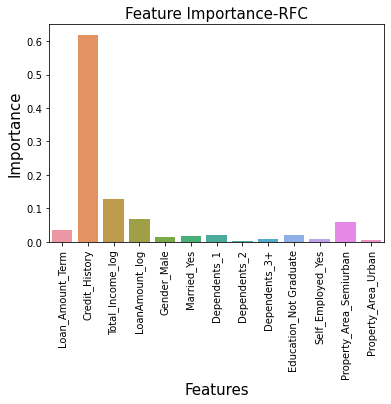

In [50]:
#Retrieving the feature importance using the feature_importances. We can do the same for DT and XGB based models.
#For logistic regression and SVM we can just take a loo to the coeficient magnitude
Feature_Importance=Results['Model'][10].best_estimator_.steps[0][1].feature_importances_ #RFC
#Results['Model'][9].best_estimator_.steps[0][1].feature_importances_ #DT
#Results['Model'][6].best_estimator_.steps[1][1].coef_ #Logreg
#Results['Model'][7].best_estimator_.steps[1][1].coef_ #SVM
#Results['Model'][11].best_estimator_.steps[1][1].feature_importances_ #xgb

plt.xticks(rotation='90')
sns.barplot(x=X.columns, y=Feature_Importance)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Importance', fontsize=15)
plt.title('Feature Importance-RFC', fontsize=15)

By a long shoot, credit history is the feature with more weight, with around 70% of the importance.


##### 3.4  Feature Engineering
We will now do some feature engineering and create new feature to see if we can improve the accuracy of the model. In particular, we are going to create the following additional features:

- Loan Amount to Total Income Ratio. Which percentage of the applicant monthly income is dedicated to pay the loan.
- Equated Monthly Installment (EMI). Monthly loan payment that includes the interest amount. o calculate it, we use the following formula: 
               EMI=B*(r(1+r)^n)/((1+r)^n-1) where B is balance, r montly interest, is the number of payments. We don't know the monthly interest. We will considerer a flat interest of 5% for all the applications.
                                       
                                       
- EMI to Total Income Ratio. Similar to Loan Amount to Total Income Ratio, but using the calculated EMI
- Has Coapplicant?. Boolean variable that just indicates is the application has a coapllicant or not.

In [64]:
#Calculated variable 1: Ratio loan to total_Income
#Convert Loan Amount from k to unit.
loan_train_prepro['Loan_to_income']=np.round(loan_train_prepro['Total_Income'].div(loan_train_prepro['LoanAmount'].mul(1000).div(loan_train_prepro['Loan_Amount_Term'])))
loan_train_prepro['Loan_to_income_log']=np.log(loan_train_prepro['Loan_to_income'])

#Calculated variable 2:Equated Monthly Payment (EMI). Apply log transform to reduce the skewness
#Formula M=B*(r(1+r)^n)/((1+r)^n-1)
#M is your monthly payment.
#B is balance
#r is your monthly interest rate 5%=>  5/12/100
#n is your number of payments (the number of months you will be paying the loan)
ir=0.05
mir=ir/12
loan_train_prepro['EMI']= loan_train_prepro['LoanAmount']*1000*((mir*(1+mir)**loan_train_prepro['Loan_Amount_Term'])/((1+mir)**loan_train_prepro['Loan_Amount_Term']-1))
loan_train_prepro['EMI_log']=np.log(loan_train_prepro['EMI'])

#Calculated variable 3: Ratio Equated Monthly Payment (EMI) to Total_Income.Apply log transform to reduce the skewness
loan_train_prepro['EMI_to_income']=np.round(loan_train_prepro['Total_Income'].div(loan_train_prepro['EMI']))
loan_train_prepro['EMI_to_income_log']=np.log(loan_train_prepro['EMI_to_income'])

#Calculated variable 4: Has codependent
loan_train_prepro['CoApplicant?']=np.where(loan_train_prepro['CoapplicantIncome']>0,1,0)

In [66]:
loan_train_prepro.columns


Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Total_Income',
       'Total_Income_log', 'LoanAmount_log', 'Gender_Male', 'Married_Yes',
       'Dependents_1', 'Dependents_2', 'Dependents_3+',
       'Education_Not Graduate', 'Self_Employed_Yes',
       'Property_Area_Semiurban', 'Property_Area_Urban', 'Loan_Status_Y',
       'Loan_to_income', 'Loan_to_income_log', 'EMI', 'EMI_log',
       'EMI_to_income', 'EMI_to_income_log', 'CoApplicant?'],
      dtype='object')

In [67]:
X=loan_train_prepro[['Loan_Amount_Term', 'Credit_History','Total_Income_log', 'LoanAmount_log', 'Gender_Male', 'Married_Yes',
       'Dependents_1', 'Dependents_2', 'Dependents_3+','Education_Not Graduate', 'Self_Employed_Yes','Property_Area_Semiurban', 'Property_Area_Urban',
       'Loan_to_income_log', 'EMI_log', 'EMI_to_income_log', 'CoApplicant?']].copy()

##### 3.5 Model with Hyperparameter tuning (Gridsearch Search), Feature Engineering, no Feature Selection

In [ ]:
start_time = time.time()
for i,j,k in zip(pipegridlist,paramgridlist,('Logreg','SVM', 'KNN', 'DTree','RF','XGB')):
    grid = GridSearchCV(i, j, cv=kf,scoring='accuracy',return_train_score='True')
    grid.fit(X,y)
    Gridsearch[k]= grid
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
for algorithm,gridresults in Gridsearch.items():
    Results.loc[len(Results)] = [algorithm, gridresults,'All original features plus calculated features',
                                     gridresults.cv_results_['mean_train_score'][gridresults.best_index_],
                                     gridresults.cv_results_['mean_test_score'][gridresults.best_index_],'Gridsearch','Original and calculated features.\
                                     Log transform. Gridsearch, No feature selection'] 